# mTBI classifier using filtered electrodes

In [1]:
#Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import pca
import glob
from tqdm import tqdm
from numpy import genfromtxt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [22]:
#Use if selecting filtered electrode models
elecrodes_to_keep = np.load('1STDElectrodes.npy')

In [23]:
#read all epoch filenames
epoch_files = sorted(glob.glob('cs791_epoch_numpy/*.npy'))

In [29]:
# loads all the EEG files into mTBI and Control arrays
ctrl_flag = 0
mtbi_flag = 0
ci , mi = 0, 0
ctrl_eeg = np.zeros((28, 4193356))
mtbi_eeg = np.zeros((56, 4193356))

for epoch_file in tqdm(epoch_files):
    tmp = epoch_file[18:].split('_')
    
    if len(tmp) == 2:
        s1, s2 = epoch_file[18:].split('_')
    if len(tmp) == 3:
        s1, s2, s3 = epoch_file[18:].split('_')
    if len(tmp) == 4:
        s1, s2, s3, s4 = epoch_file[18:].split('_')
    if len(tmp) == 5:
        s1, s2, s3, s4, s5 = epoch_file[18:].split('_')


    if s2[:7]=='Control':
        temp_ctrl = np.load(epoch_file)
        if temp_ctrl.shape[1] == 263:
            temp_ctrl = temp_ctrl[:,:-1,:]
        temp_ctrl = np.mean(temp_ctrl, axis =0)
        temp_ctrl = temp_ctrl[elecrodes_to_keep,0:-1:3]
        temp_ctrl = temp_ctrl.flatten()
        #temp_ctrl = np.mean(temp_ctrl, axis =0)
        ctrl_eeg[ci,:] = temp_ctrl
        ci += 1
        
    else:
        temp_mtbi = np.load(epoch_file)
        if temp_mtbi.shape[1] == 263:
            temp_mtbi = temp_mtbi[:,:-1,:]
        temp_mtbi = np.mean(temp_mtbi, axis =0)
        temp_mtbi = temp_mtbi[elecrodes_to_keep,0:-1:3]
        temp_mtbi = temp_mtbi.flatten()
        #temp_mtbi = np.mean(temp_mtbi, axis =0)
        mtbi_eeg[mi,:] = temp_mtbi
        mi += 1
np.savez('mTBI_arr_1STD.npz', mtbi_eeg)
np.savez('ctrl_arr_1STD.npz', ctrl_eeg)

100%|███████████████████████████████████████████| 84/84 [10:13<00:00,  7.30s/it]


In [2]:
# Loading saved arrays incase we dont want to run them again
mtbi_eeg = np.load('mTBI_arr.npz') 
ctrl_eeg = np.load('ctrl_arr.npz')

mtbi_eeg = mtbi_eeg.f.arr_0
ctrl_eeg = ctrl_eeg.f.arr_0

In [3]:
print(mtbi_eeg.shape, ctrl_eeg.shape)

(56, 16156754) (28, 16156754)


In [4]:
# Generating training labels
mtbi_labels = np.ones(len(mtbi_eeg))
ctrl_labels = np.zeros(len(ctrl_eeg))

In [5]:
y = np.hstack((mtbi_labels,ctrl_labels))
y_train = np.hstack((mtbi_labels[:-10], ctrl_labels[:-10]))
y_test = np.hstack((mtbi_labels[-10:], ctrl_labels[-10:]))

In [6]:
#Generating train and test splits
X = np.vstack((mtbi_eeg,ctrl_eeg))
X_train = np.vstack((mtbi_eeg[:-10],ctrl_eeg[:-10]))
X_test = np.vstack((mtbi_eeg[-10:],ctrl_eeg[-10:]))

In [7]:
#running logistic regression
clf = LogisticRegression(random_state=0, class_weight='balanced').fit(X_train, y_train)

/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [18]:
# getting weights of the logistic regression model
weights = clf.coef_

In [21]:
#calculating mean weights
mean_weights = np.mean(weights.reshape(temp_ctrl.shape[1], temp_ctrl.shape[0]), axis =0)

In [22]:
np.save('EGI_weights_2STD.npy', mean_weights)

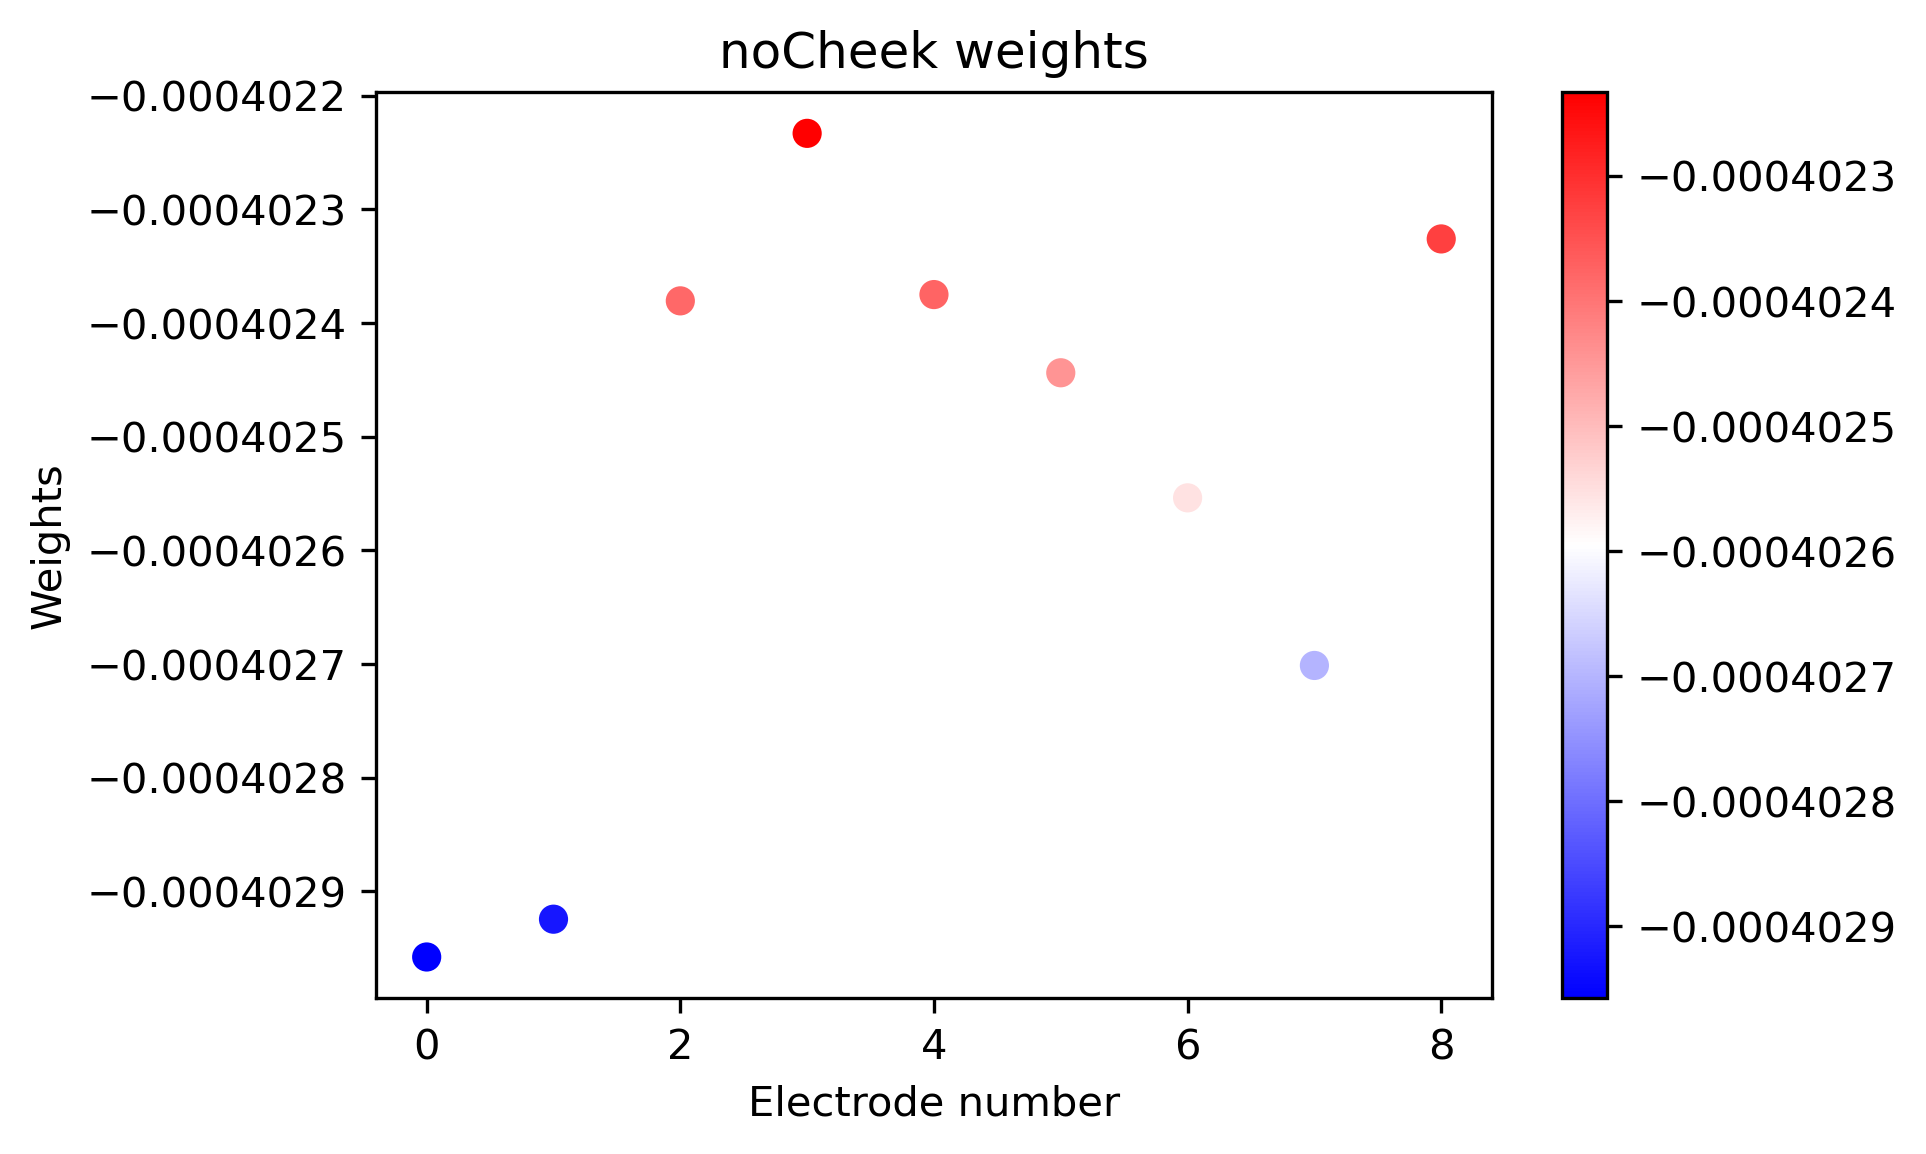

In [23]:
#Weights sanity check plot
plt.figure(dpi=300)
plt.scatter(np.arange(len(mean_weights)), mean_weights, c=mean_weights, cmap = 'bwr')
plt.ylabel('Weights')
plt.xlabel('Electrode number')
plt.title('noCheek weights')
plt.colorbar()

In [15]:
# Prediction on test set
clf.predict(X_test)

array([0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1.,
       0., 1., 0.])

In [16]:
#Actual test set
y_test

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [ ]:
#Runnig cross-validation

In [9]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
# create dataset
cv = KFold(n_splits=2, random_state=1, shuffle=True)
# create model
model = LogisticRegression(random_state=0, class_weight='balanced')
# evaluate model
scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/nump

/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/nump

/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/nump

/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/nump

/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/nump

/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/nump

/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/nump

/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/nump

/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/nump

/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/nump

/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/nump

/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/externals/joblib/nump

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

# Sleep profiler analysis

In [2]:
#Loading filenames
mTBI_ID = genfromtxt('mTBI_IDs.csv')
Control_ID = genfromtxt('Control_IDs.csv')

In [3]:
Control_ID = Control_ID[1:]
mTBI_ID = mTBI_ID[1:]

In [72]:
epoch_files = sorted(glob.glob('cs791_power_SP/*psds.npy'))

In [23]:
#Loading mTBI and COntrol data into arrays
ctrl_eeg = np.zeros((len(Control_ID), 92160))
mtbi_eeg = np.zeros((len(mTBI_ID), 92160))
ci = 0
mi = 0


all_IDs = np.hstack((Control_ID, mTBI_ID))
for i, ids in tqdm(enumerate(all_IDs)):

    if i<95:
        temp_ctrl = np.load('cs791_epoch_SP/'+str(int(ids))+'-epoch.npy')
        temp_ctrl = np.mean(temp_ctrl, axis =0)
        temp_ctrl = temp_ctrl.flatten()
        #temp_ctrl = np.mean(temp_ctrl, axis =0)
        ctrl_eeg[ci,:] = temp_ctrl
        ci += 1
        
    else:
        temp_mtbi = np.load('cs791_epoch_SP/'+str(int(ids))+'-epoch.npy')
        temp_mtbi = np.mean(temp_mtbi, axis =0)
        temp_mtbi = temp_mtbi.flatten()
        mtbi_eeg[mi,:] = temp_mtbi
        mi += 1
    
np.savez('mTBI_SP_arr.npz', mtbi_eeg)
np.savez('ctrl_SP_arr.npz', ctrl_eeg)

199it [00:00, 816.85it/s]


In [ ]:
#Using a scaler to z-score features

In [15]:
scaler = StandardScaler(with_std=False)
mtbi_eeg = scaler.fit_transform(mtbi_eeg)
ctrl_eeg = scaler.fit_transform(ctrl_eeg)

In [27]:
#Generating mTBI and control labels and splotoing dataset
mtbi_labels = np.ones(len(mTBI_ID))
ctrl_labels = np.zeros(len(Control_ID))
y = np.hstack((mtbi_labels,ctrl_labels))
y_train = np.hstack((mtbi_labels[:-5], ctrl_labels[:-5]))
y_test = np.hstack((mtbi_labels[-5:], ctrl_labels[-5:]))
X = np.vstack((ctrl_eeg,mtbi_eeg))
X_train = np.vstack((mtbi_eeg[:-5],ctrl_eeg[:-5]))
X_test = np.vstack((mtbi_eeg[-5:],ctrl_eeg[-5:]))

In [18]:
#runnign logistic regression
clf = LogisticRegression(random_state=0, class_weight='balanced').fit(X_train, y_train)

/home/arnabb/anaconda3/envs/pomlab/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [4]:
#k fold cross val

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
# create dataset
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# create model
model = LogisticRegression(random_state=0)
# evaluate model
scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

In [9]:
from sklearn import metrics

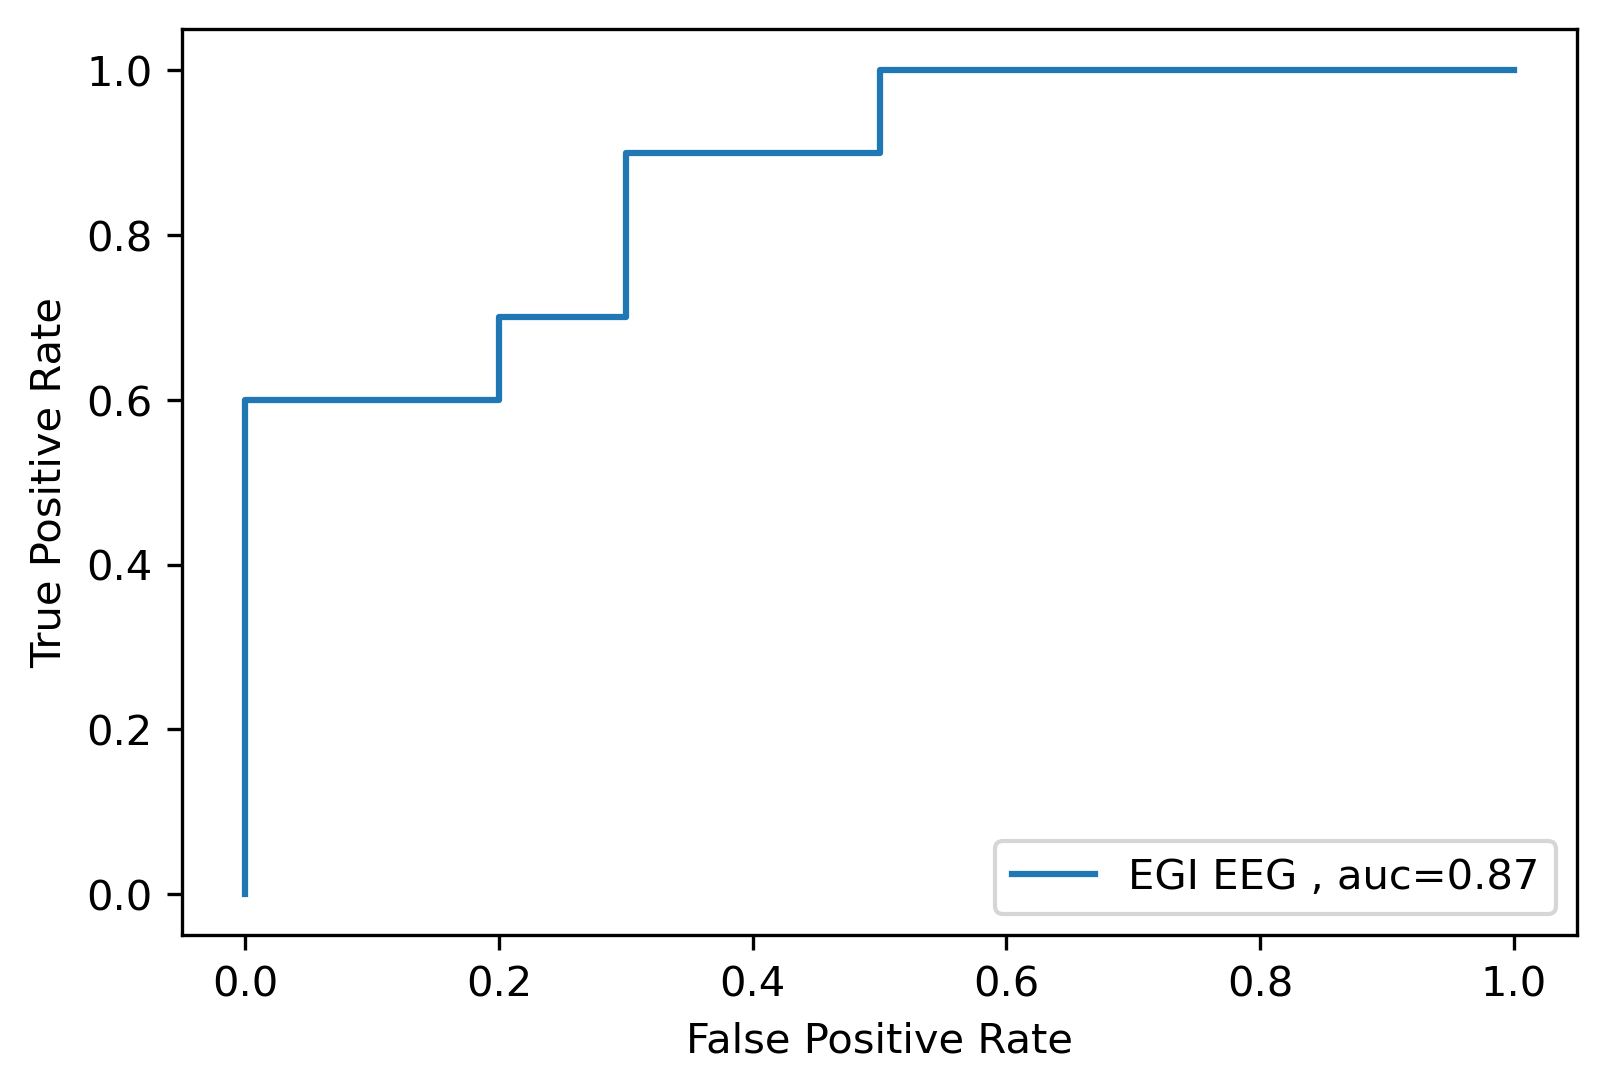

In [10]:
# Generating ROC plot
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.figure(dpi=300)
plt.plot(fpr,tpr,label="EGI EEG , auc="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
#Generating ROC plots for all EGI models

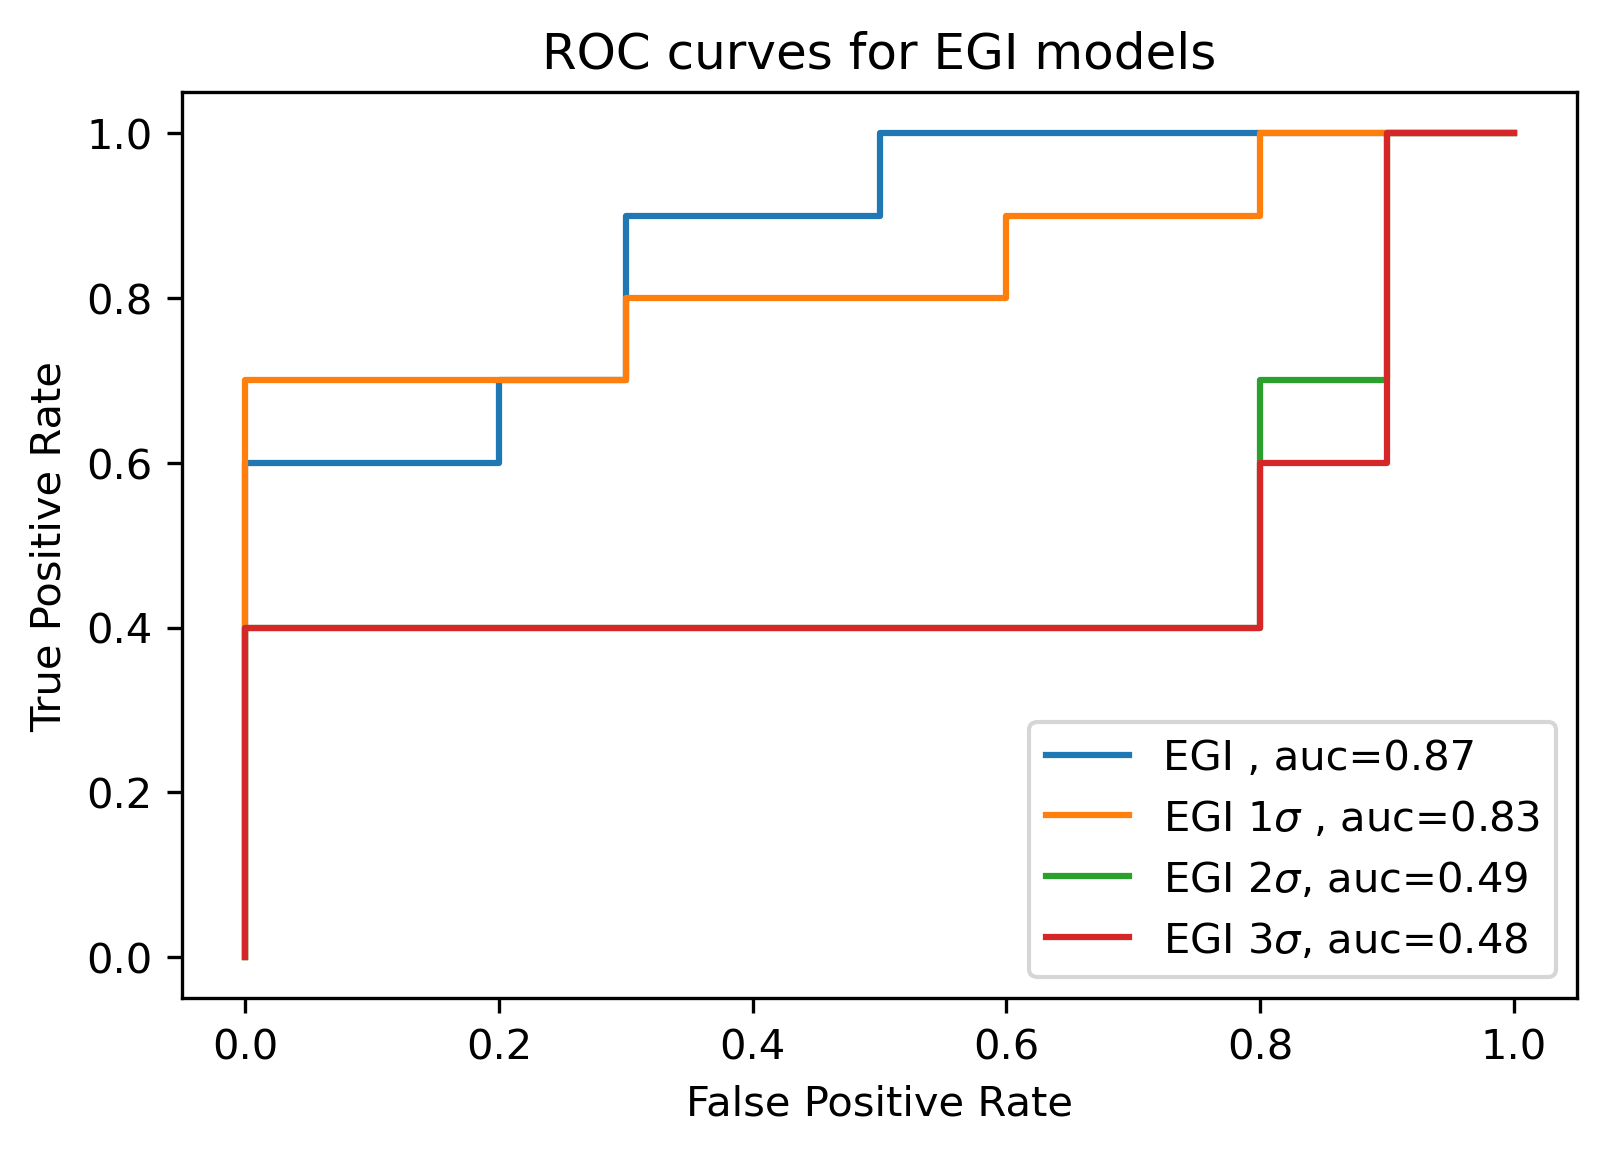

In [15]:
y_pred_proba_0 = np.load('0STD_prob.npy')
fpr_0, tpr_0, _ = metrics.roc_curve(y_test,  y_pred_proba_0)
auc_0 = metrics.roc_auc_score(y_test, y_pred_proba_0)

y_pred_proba_1 = np.load('1STD_prob.npy')
fpr_1, tpr_1, _ = metrics.roc_curve(y_test,  y_pred_proba_1)
auc_1 = metrics.roc_auc_score(y_test, y_pred_proba_1)

y_pred_proba_2 = np.load('2STD_prob.npy')
fpr_2, tpr_2, _ = metrics.roc_curve(y_test,  y_pred_proba_2)
auc_2 = metrics.roc_auc_score(y_test, y_pred_proba_2)

y_pred_proba_3 = np.load('3STD_prob.npy')
fpr_3, tpr_3, _ = metrics.roc_curve(y_test,  y_pred_proba_3)
auc_3 = metrics.roc_auc_score(y_test, y_pred_proba_3)
auc_3 = 0.48
plt.figure(dpi=300)
plt.plot(fpr_0,tpr_0,label="EGI , auc="+str(auc_0))
plt.plot(fpr_1,tpr_1,label="EGI 1$\sigma$ , auc="+str(auc_1))
plt.plot(fpr_2,tpr_2,label="EGI 2$\sigma$, auc="+str(auc_2))
plt.plot(fpr_3,tpr_3,label="EGI 3$\sigma$, auc="+str(auc_3))
plt.legend(loc=4)
plt.title('ROC curves for EGI models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
#Freq space model using SP data

In [189]:
ctrl_eeg = np.zeros((len(Control_ID), 7135))
mtbi_eeg = np.zeros((len(mTBI_ID), 7135))
ci = 0
mi = 0

all_IDs = np.hstack((Control_ID, mTBI_ID))
for i, ids in tqdm(enumerate(all_IDs)):

    if i<95:
        temp_ctrl = np.load('cs791_power_SP/'+str(int(ids))+'-psds.npy')
        temp_ctrl = np.mean(temp_ctrl, axis =0)
        temp_ctrl = temp_ctrl.flatten()
        #temp_ctrl = np.mean(temp_ctrl, axis =0)
        ctrl_eeg[ci,:] = temp_ctrl
        ci += 1
        
    else:
        temp_mtbi = np.load('cs791_power_SP/'+str(int(ids))+'-psds.npy')
        temp_mtbi = np.mean(temp_mtbi, axis =0)
        temp_mtbi = temp_mtbi.flatten()
        mtbi_eeg[mi,:] = temp_mtbi
        mi += 1
np.savez('mTBI_SP_arr.npz', mtbi_eeg)
np.savez('ctrl_SP_arr.npz', ctrl_eeg)

199it [00:00, 2667.40it/s]


In [190]:
mtbi_labels = np.ones(len(mTBI_ID))
ctrl_labels = np.zeros(len(Control_ID))
y = np.hstack((mtbi_labels,ctrl_labels))
y_train = np.hstack((mtbi_labels[:-5], ctrl_labels[:-5]))
y_test = np.hstack((mtbi_labels[-5:], ctrl_labels[-5:]))
X = np.vstack((ctrl_eeg,mtbi_eeg))
X_train = np.vstack((mtbi_eeg[:-5],ctrl_eeg[:-5]))
X_test = np.vstack((mtbi_eeg[-5:],ctrl_eeg[-5:]))

In [ ]:
#runnign logistic regression
clf = LogisticRegression(random_state=0, class_weight='balanced').fit(X_train, y_train)

In [ ]:
#k fold cross val

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
# create dataset
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# create model
model = LogisticRegression(random_state=0)
# evaluate model
scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))